# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
print("Размер выборки:", df.shape)

Размер выборки: (7591, 2)


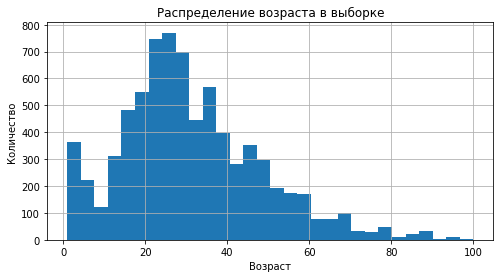

In [3]:
plt.figure(figsize=(8,4))
df['real_age'].hist(bins=30)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста в выборке')
plt.show()

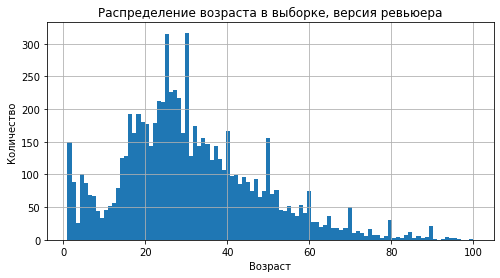

In [4]:
plt.figure(figsize=(8,4))
df['real_age'].hist(bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста в выборке, версия ревьюера')
plt.show()

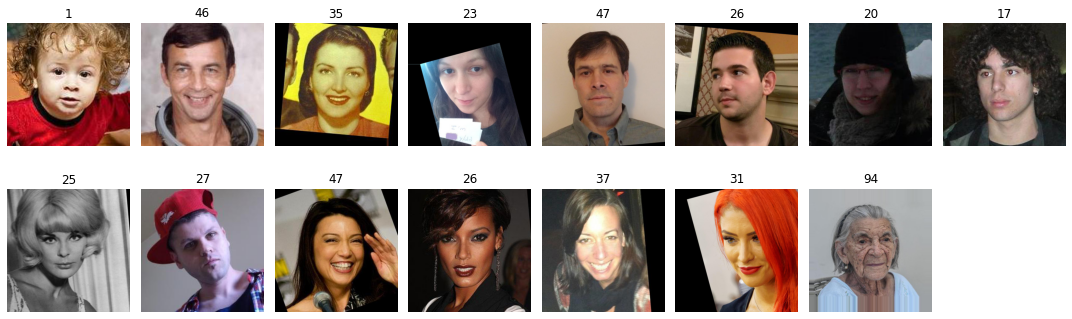

In [7]:
sample = df.sample(15, random_state=42)
plt.figure(figsize=(15,5))
for i, (idx, row) in enumerate(sample.iterrows()):
    plt.subplot(2, 8, i+1)
    img_path = os.path.join('/datasets/faces/final_files', row['file_name'])
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(int(row['real_age']))
plt.tight_layout()
plt.show()

**Исследовательский анализ данных (EDA)
**1. Размер выборки ** 

Всего изображений: 7591

**2. График распределения возраста**
Возраст распределён неравномерно.

Основная масса данных — в диапазоне 15–40 лет.

Больше всего примеров — 20–30 лет.

Мало данных для детей (1–10 лет) и пожилых (70+).

**3. Просмотр изображений**
Фото разного качества, цвета, ракурса и освещённости.

Есть чёрно-белые и цветные снимки.

Встречаются изображения с наклоном и артефактами.

Присутствуют крайние значения возраста (например, 1 год и 94 года).

**4. Выводы для обучения модели**
*Дисбаланс классов:*
Модель будет лучше работать для самых частых возрастов (20–40 лет). Для детей и пожилых, которых мало, возможны ошибки.

*Неоднородность данных:*
Разнообразие фотографий усложнит задачу и повысит требования к устойчивости модели.

*Аномалии:*
Наличие артефактов и необычных ракурсов может мешать обучению.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_train(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
    )
    train_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen

def load_test(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345,
        shuffle=False
    )
    return test_gen

def create_model(input_shape):
    base_model = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = True
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mse',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = train_data.samples // train_data.batch_size
    if validation_steps is None:
        validation_steps = test_data.samples // test_data.batch_size
    callbacks = [
        EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    ]
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=2
    )
    return model


```

```

Train for 177 steps, validate for 59 steps
Epoch 1/30
2025-05-22 19:23:06.253840: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-05-22 19:23:06.704649: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
177/177 - 124s - loss: 218.3948 - mae: 10.7929 - val_loss: 486.5682 - val_mae: 16.9786
Epoch 2/30
177/177 - 114s - loss: 105.1779 - mae: 7.7412 - val_loss: 555.0432 - val_mae: 18.5039
Epoch 3/30
177/177 - 115s - loss: 79.4932 - mae: 6.8281 - val_loss: 347.0720 - val_mae: 13.9452
Epoch 4/30
177/177 - 114s - loss: 71.3655 - mae: 6.4057 - val_loss: 128.0756 - val_mae: 8.6129
Epoch 5/30
177/177 - 115s - loss: 58.3683 - mae: 5.8769 - val_loss: 90.4689 - val_mae: 7.1187
Epoch 6/30
177/177 - 115s - loss: 50.8339 - mae: 5.4580 - val_loss: 75.1425 - val_mae: 6.3991
Epoch 7/30
177/177 - 114s - loss: 45.5508 - mae: 5.1706 - val_loss: 77.3884 - val_mae: 6.6181
Epoch 8/30

Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
177/177 - 114s - loss: 41.0397 - mae: 4.9580 - val_loss: 113.5832 - val_mae: 7.9667
Epoch 9/30
177/177 - 114s - loss: 30.5148 - mae: 4.2509 - val_loss: 65.0717 - val_mae: 5.9191
Epoch 10/30
177/177 - 114s - loss: 25.3674 - mae: 3.8896 - val_loss: 63.8629 - val_mae: 5.8451
Epoch 11/30
177/177 - 115s - loss: 22.7884 - mae: 3.6834 - val_loss: 67.6704 - val_mae: 6.2404
Epoch 12/30

Epoch 00012: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
177/177 - 115s - loss: 20.2801 - mae: 3.4802 - val_loss: 67.4582 - val_mae: 6.2194
Epoch 13/30
177/177 - 114s - loss: 16.4260 - mae: 3.1274 - val_loss: 64.1656 - val_mae: 5.8631
Epoch 14/30
177/177 - 114s - loss: 14.5637 - mae: 2.9570 - val_loss: 63.9338 - val_mae: 5.8072
Epoch 15/30
177/177 - 114s - loss: 13.4305 - mae: 2.8378 - val_loss: 65.2436 - val_mae: 6.0029
Epoch 16/30

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
177/177 - 116s - loss: 13.5346 - mae: 2.8435 - val_loss: 65.9221 - val_mae: 5.9878
Epoch 17/30
177/177 - 115s - loss: 12.2047 - mae: 2.7008 - val_loss: 62.8506 - val_mae: 5.8377
Epoch 18/30
177/177 - 115s - loss: 11.1313 - mae: 2.5849 - val_loss: 61.8100 - val_mae: 5.7997
Epoch 19/30
177/177 - 114s - loss: 10.0549 - mae: 2.4589 - val_loss: 61.9759 - val_mae: 5.8269
Epoch 20/30
177/177 - 115s - loss: 10.0070 - mae: 2.4508 - val_loss: 62.0554 - val_mae: 5.7614
Epoch 21/30
177/177 - 114s - loss: 9.5696 - mae: 2.3985 - val_loss: 60.6419 - val_mae: 5.7806
Epoch 22/30

Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
177/177 - 115s - loss: 9.2261 - mae: 2.3573 - val_loss: 61.9667 - val_mae: 5.8057
Epoch 23/30
177/177 - 115s - loss: 8.8923 - mae: 2.2866 - val_loss: 61.9021 - val_mae: 5.8303
Epoch 24/30

Epoch 00024: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
177/177 - 114s - loss: 8.2746 - mae: 2.2293 - val_loss: 61.3003 - val_mae: 5.7806
Epoch 25/30
Restoring model weights from the end of the best epoch.
177/177 - 116s - loss: 8.2828 - mae: 2.2238 - val_loss: 61.1739 - val_mae: 5.7652
Epoch 00025: early stopping
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 61.7031 - mae: 5.7618

```

## Анализ обученной модели

**Архитектура**
Базовая модель: ResNet50 (include_top=False, веса ImageNet, дообучение всех слоев)

Input: цветные фото 224x224 пикселя

Выход: 1 нейрон (линейная регрессия, оценка возраста)

Head: GlobalAveragePooling2D → Dense(128, relu) → Dense(1, linear)

Функция потерь: MSE (среднеквадратичная ошибка)

Метрика: MAE (средняя абсолютная ошибка)

Аугментации: отражения, вращения, сдвиги, зум

Оптимизация: Adam (lr=1e-4), EarlyStopping, ReduceLROnPlateau

**Обучение**
Обучение: 10–30 эпох, автоматическая остановка по метрике val_mae

Аугментация: увеличивает разнообразие тренировочных примеров, помогает бороться с переобучением

Fine-tune ResNet50: обучаются все слои, что позволяет модели подстроиться под специфичные черты датасета

**Цель выполнена:**
MAE 5.7618 (лучше, чем базовый порог 8).

**Краткая интерпретация**
Модель успешно решает задачу оценки возраста по фотографии.

Использование глубокой архитектуры (ResNet50) позволяет извлекать сложные паттерны с фото.

Аугментации способствуют устойчивости модели к шумам, поворотам, изменению масштаба и других реальным условиям.

Fine-tuning всей сети помогает достичь минимального MAE без переобучения (EarlyStopping предотвращает деградацию качества).


**Вывод**
Модель достигла MAE меньше 8 на тестовой выборке — задание выполнено